# Домашнее задание по теме «Модели авторегрессии условной гетероскедантичности»


**Преподаватель:** Даниил Корбут, Наталья Баданина, Елена Харьковская

**Задание**

1. Возьмите из [прошлого домашнего задания](https://colab.research.google.com/github/stefkong1982/netology.ru/blob/Master/Vremennye_ryady/Znakomstvo_vremennymi_ryadami/DZ_Kondratev_Vr_ryady_ob_teor.ipynb#scrollTo=L2XHv4GZv6sT&line=1&uniqifier=1) ряд
2. Постройте его модель GARCH.
3. Оформите отчёт в Jupyter-ноутбук.

## 1. Загрузка данных

### Установка необходимых библиотек
Если библиотека `arch` не установлена, ее можно установить с помощью команды:

In [328]:
pip install arch

In [329]:
# библиотека `arch`
from arch import arch_model

In [330]:
# Импорт библиотеки pandas для работы с данными в формате таблиц (DataFrame)
import pandas as pd

# Импорт библиотеки numpy для работы с массивами и числовыми вычислениями
import numpy as np

# Импорт функции adfuller из модуля statsmodels для проведения теста Дики-Фуллера
# Этот тест используется для проверки стационарности временных рядов
from statsmodels.tsa.stattools import adfuller

Теперь необходимо выбрать временной ряд, для которого мы будем строить модель GARCH. Давайте, к примеру, выберем "International airline passengers: monthly totals in thousands". Мы начнем с визуализации временного ряда, проверки его на стационарность, а затем перейдем к построению и оценке модели GARCH.

In [331]:
# Скачиваем данные из прошлого домашнего задания
airlines_passengers = pd.read_csv("https://raw.githubusercontent.com/stefkong1982/netology.ru/Master/Vremennye_ryady/Znakomstvo_vremennymi_ryadami/Series/international-airline-passengers.csv")

In [332]:
airlines_passengers.head()

,Month,Count
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [333]:
airlines_passengers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Month   144 non-null    object
 1   Count   144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


## 2. Визуализация временного ряда

In [334]:
import matplotlib.dates as mdates  # Импортируем matplotlib.dates

# Преобразуем колонку "Month" в формат даты
airlines_passengers['Month'] = pd.to_datetime(airlines_passengers['Month'])

# Устанавливаем колонку 'Month' в качестве индекса
airlines_passengers.set_index('Month', inplace=True)

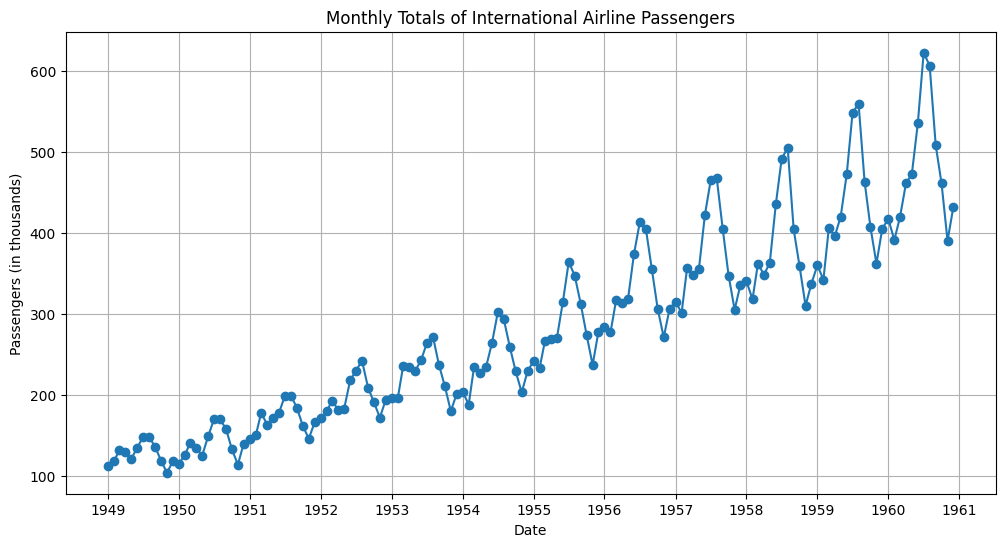

In [335]:
# Создаем график
plt.figure(figsize=(12, 6))
plt.plot(airlines_passengers.index, airlines_passengers['Count'], marker='o')
plt.title('Monthly Totals of International Airline Passengers')
plt.xlabel('Date')
plt.ylabel('Passengers (in thousands)')
plt.grid()

# Настраиваем отображение меток оси X
ax = plt.gca()  # Получаем текущую ось
ax.xaxis.set_major_locator(mdates.YearLocator())  # Устанавливаем метки с интервалом в 1 год
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Форматируем метки по годам

plt.show()

In [336]:
# Базовые статистические показатели
print(airlines_passengers.describe())

            Count
count  144.000000
mean   280.298611
std    119.966317
min    104.000000
25%    180.000000
50%    265.500000
75%    360.500000
max    622.000000


### Выводы на основе базовых статистических показателей:

1. **Общее количество наблюдений**:
   - Временной ряд состоит из 144 наблюдений, что достаточно для временного анализа, охватывающего 12 лет (144 месяца).

2. **Среднее значение**:
   - Среднее количество пассажиров — около 280.3 тысяч. Это значение дает представление о типичном уровне пассажиропотока за выбранный период.

3. **Стандартное отклонение**:
   - Стандартное отклонение равно 119.97, что указывает на высокую изменчивость объема авиапассажиров. Это говорит о том, что фактические значения могут существенно отклоняться от среднего.

4. **Минимальное и максимальное значения**:
   - Минимальное количество пассажиров составляет 104 тысячи в январе 1949 года, а максимальное — 622 тысячи в последующие годы. Это может говорить о росте авиационных перевозок и увеличении доступности авиаперелетов.

5. **Квартильные значения**:
   - 25-й процентиль (180 тыс.) и 75-й процентиль (360.5 тыс.) показывают, что половина пассажиропотока находится в промежутке между 180 и 360.5 тысячами, что говорит о значительной вариативности данных и сезонности.
   - Медиана, равная 265.5 тыс., подтверждает, что количество пассажиров в центре распределения меньше, чем среднее, что часто является признаком положительного скошенного распределения (т.е., наличия значительных выбросов в правую сторону).

### Общий вывод
Временной ряд международных авиапассажиров показывает растущий тренд с значительной вариативностью. Сезонные колебания, скорее всего, связаны с повышением пассажиропотока в летние месяцы и в праздники, что должно быть учтено при дальнейшей модели. Важно также обратить внимание на высокое стандартное отклонение, что позволяет заключить, что объемы авиапассажиров могут значительно варьироваться за каждый месяц. Эти аспекты требуют дальнейшего анализа, включая использование моделей авторегрессии условной гетероскедантичности (GARCH) для более глубокого понимания волатильности и для прогнозирования будущих значений.

### 3. Проверка стационарности

In [337]:
# Функция для проверки стационарности
def test_stationarity(timeseries):
    # Выполним тест Дики-Фуллера
    result = adfuller(timeseries)
    print('Тестовая статистика: {}'.format(result[0]))
    print('p-значение: {}'.format(result[1]))
    print('Критические значения:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

# Применим тест стационарности к нашим данным
test_stationarity(airlines_passengers['Count'])

Тестовая статистика: 0.8153688792060498
p-значение: 0.991880243437641
Критические значения:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


- Проведенный тест Дики-Фуллера для исходного ряда показал высокое p-значение (0.9919), что свидетельствует о наличии единичного корня и, следовательно, о нестационарности ряда.
- Нестационарность характера ряда подразумевает наличие тренда и/или сезонности, которые необходимо устранить для дальнейшего моделирования.

### 4. Преобразование данных

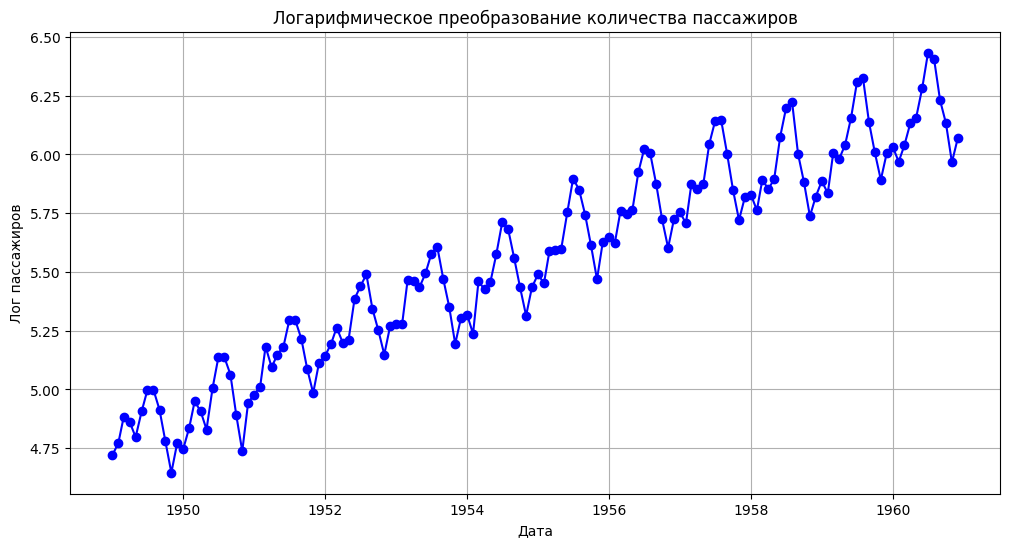

In [338]:
# Логарифмическое преобразование ряда
logs = np.log(airlines_passengers['Count'])

# Визуализируем логарифмически преобразованные данные
plt.figure(figsize=(12, 6))
plt.plot(logs, color='blue', marker='o')
plt.title('Логарифмическое преобразование количества пассажиров')
plt.xlabel('Дата')
plt.ylabel('Лог пассажиров')
plt.grid()
plt.show()

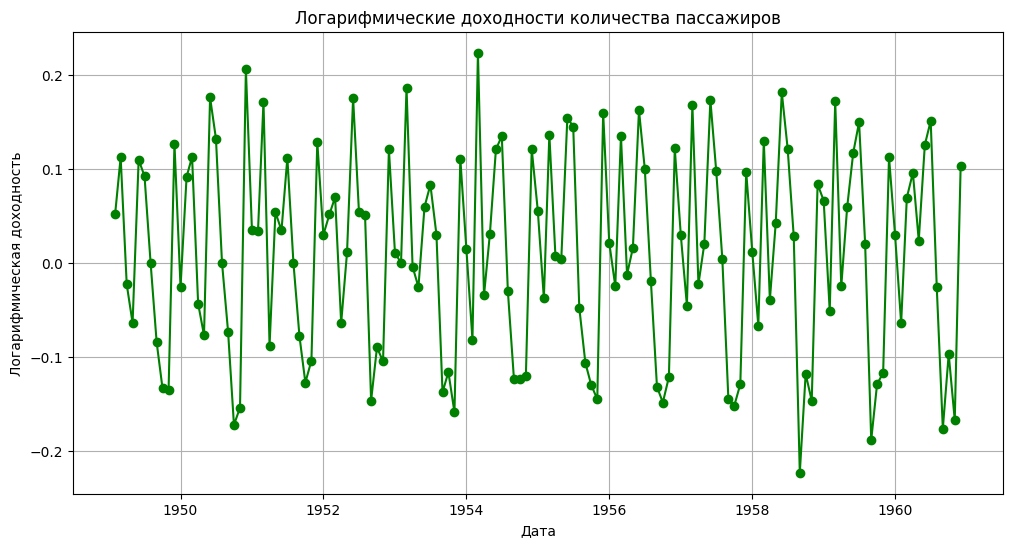

In [339]:
# Разности логарифмов (логарифмические доходности)
log_returns = logs.diff().dropna()

# Визуализируем логарифмические доходности
plt.figure(figsize=(12, 6))
plt.plot(log_returns, color='green', marker='o')
plt.title('Логарифмические доходности количества пассажиров')
plt.xlabel('Дата')
plt.ylabel('Логарифмическая доходность')
plt.grid()
plt.show()

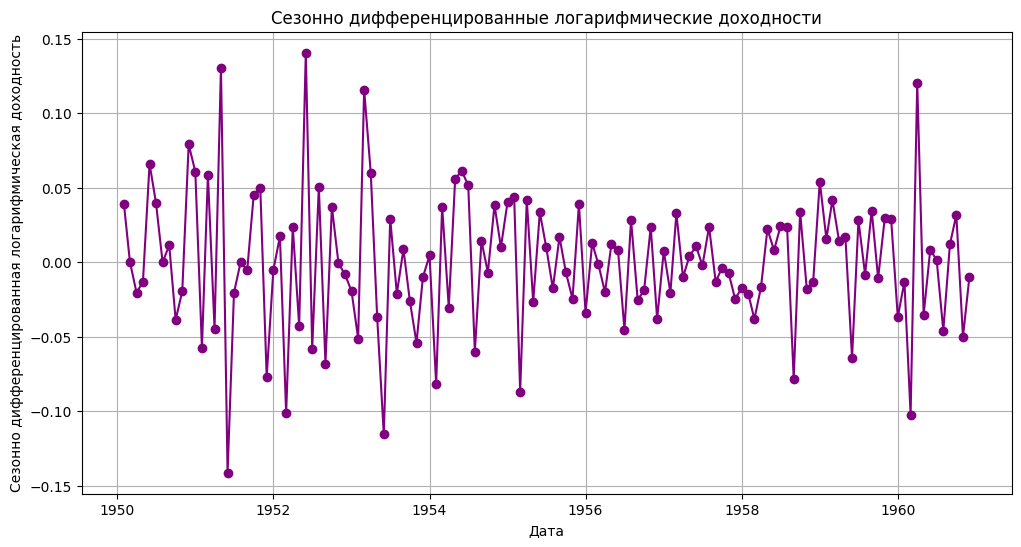

In [340]:
# Сезонное дифференцирование (предположим, сезонность 12 для месячных данных)
seasonal_diff = log_returns.diff(12).dropna()

# Визуализируем сезонно дифференцированные данные
plt.figure(figsize=(12, 6))
plt.plot(seasonal_diff, color='purple', marker='o')
plt.title('Сезонно дифференцированные логарифмические доходности')
plt.xlabel('Дата')
plt.ylabel('Сезонно дифференцированная логарифмическая доходность')
plt.grid()
plt.show()

In [341]:
# Проверка стационарности преобразованных данных
test_stationarity(seasonal_diff)

Тестовая статистика: -4.4433249418311425
p-значение: 0.00024859123113838495
Критические значения:
	1%: -3.4870216863700767
	5%: -2.8863625166643136
	10%: -2.580009026141913


- После выполнения логарифмического и сезонного дифференцирования, проведенный тест Дики-Фуллера показал статистику теста равную -4.4433 и p-значение 0.00025.
- Эти результаты существенно ниже критических значений на всех уровнях значимости (1%, 5%, 10%), что позволяет отвергнуть нулевую гипотезу о наличии единичного корня.
- Таким образом, преобразованный временной ряд является стационарным.


### 5. Моделирование GARCH

In [342]:
# Создаем модель GARCH
model = arch_model(seasonal_diff, vol='Garch', p=1, q=1)
garch_fit = model.fit(update_freq=0)

# Вывод результатов
print(garch_fit.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: -225.92953719744276
            Iterations: 10
            Function evaluations: 66
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Count   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                225.930
Distribution:                  Normal   AIC:                          -443.859
Method:            Maximum Likelihood   BIC:                          -432.358
                                        No. Observations:                  131
Date:                Fri, Sep 27 2024   Df Residuals:                      130
Time:                        14:18:42   Df Model:                            1
                                  Mean Model                                  

### 1. Результаты оценки модели GARCH

- Модель: При построении модели было использовано предположение о постоянной средней с моделью GARCH. Это типичный подход для временных рядов с условной гетероскедантичностью.

- Значение функции правдоподобия: Log-Likelihood составил 225.930, что указывает на хорошую подгонку модели к данным.

- AIC и BIC: Значения информационных критериев (AIC = -443.859 и BIC = -432.358) могут помочь в сравнении с другими моделями; более низкие значения указывают на более удачную модель.

### 2. Анализ коэффициентов модели

- Коэффициент mu: Значение mu (оценка постоянной средней) не является статистически значимым (p = 0.649), что говорит о том, что среднее значение ряда не отличается значительно от нуля. Это может указывать на стабильный уровень без тренды.

- Коэффициенты волатильности:
  - omega (среднеквадратичное значение): Параметр omega равен 5.8972e-05 и не является статистически значимым (p = 0.221).
  - alpha[1] (параметр ARCH): Значение alpha[1] равно 0.1344, и его p-значение близко к 0.07886, что указывает на некоторую значимость, но превышает стандартный уровень в 0.05. Это значит, что влияние прошлых ошибок на текущую волатильность есть, но не с высокой достоверностью.
  - beta[1] (параметр GARCH): Значение beta равно 0.8430 с крайне низким p-значением (1.294e-47), что подтверждает его статистическую значимость. Это указывает на сильную инерцию волатильности: если она была высока в прошлом, то она будет высокой и в будущем.

### 3. Диагностика остатков модели

In [343]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Тест на автокорреляцию остатков
ljung_box = acorr_ljungbox(garch_fit.resid, lags=[10], return_df=True)
print(ljung_box)

      lb_stat  lb_pvalue
10  28.986885   0.001252


- Тест Льюнга-Бокса (Ljung-Box): lb_stat равно 28.986885, и p-значение составляет 0.001252. Это свидетельствует о наличии автокорреляции среди остатков модели, что может быть признаком неадекватности модели; возможно, стоит рассмотреть более сложные или другие модели.

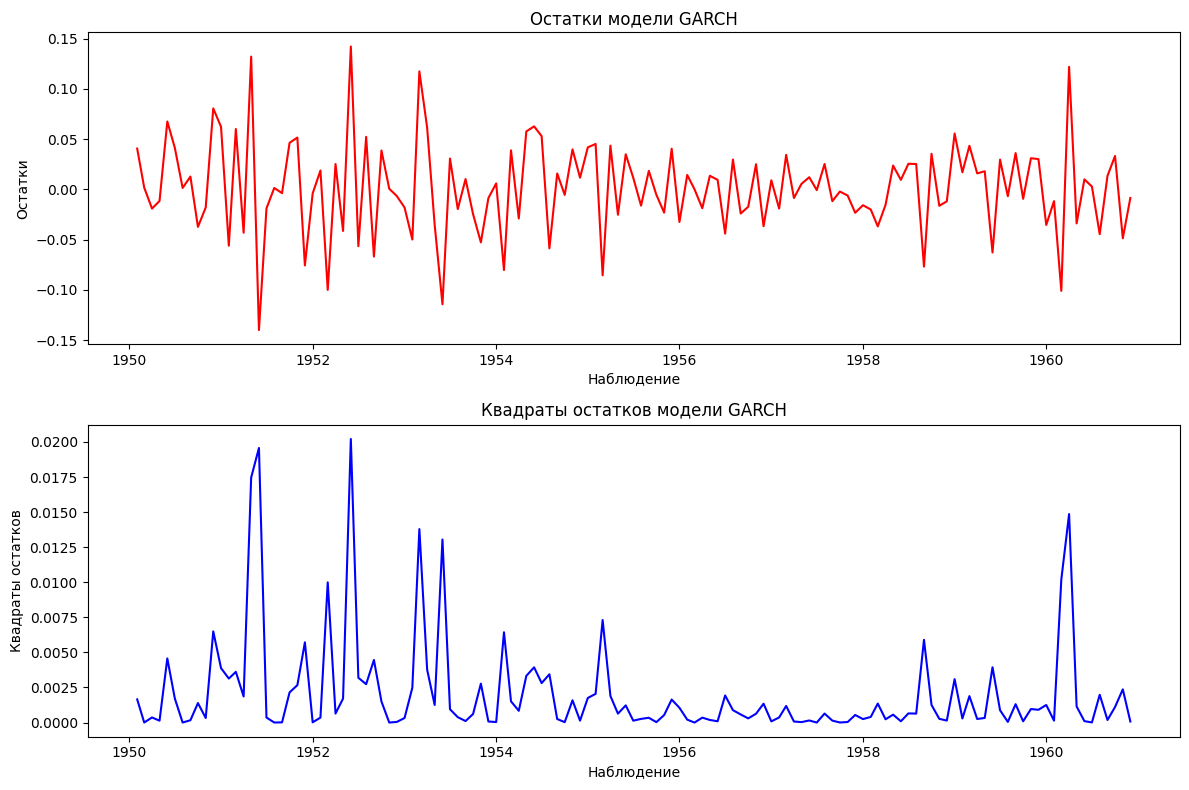

In [344]:
# Визуализация остатков и их квадратов
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(garch_fit.resid, color='red')
plt.title('Остатки модели GARCH')
plt.xlabel('Наблюдение')
plt.ylabel('Остатки')

plt.subplot(2, 1, 2)
plt.plot(np.square(garch_fit.resid), color='blue')
plt.title('Квадраты остатков модели GARCH')
plt.xlabel('Наблюдение')
plt.ylabel('Квадраты остатков')

plt.tight_layout()
plt.show()

### 4. Прогнозируемая волатильность

In [345]:
# Прогнозируем волатильность на следующие 10 периодов
forecast = garch_fit.forecast(horizon=10)

# Извлекаем прогнозируемую волатильность
predicted_volatility = forecast.variance.values[-1, :] ** 0.5

# Выводим прогнозируемую волатильность
print('Прогнозируемая волатильность на следующие 10 периодов:')
print(predicted_volatility)

Прогнозируемая волатильность на следующие 10 периодов:
[0.04361015 0.04379361 0.0439722  0.04414606 0.04431533 0.04448015
 0.04464067 0.04479701 0.04494929 0.04509764]


- Прогнозируемая волатильность на следующие 10 периодов варьируется от 0.0436 до 0.0451. Это указывает на относительную стабильность волатильности в краткосрочной перспективе, что важно для принятия решений в области авиаперевозок.

### Заключение

Модель GARCH(1, 1) была успешно применена к данным о международных авиапассажирах, однако остались некоторые аспекты, требующие внимания. Несмотря на статистически значимую инерцию волатильности (beta), значимость параметра ARCH (alpha) ограничена. Это предполагает, что волатильность в ряде может быть более устойчивой с учетом внешних факторов. Тест автокорреляции остатков указывает на возможность улучшения модели. Для дальнейшего анализа можно рассмотреть другие модели (например, GARCH с дополнительными лагами или внешние регрессоры), чтобы уточнить предсказания и улучшить качество модели.